In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns

### load datasets

In [2]:
df_TOCC=pd.read_csv("../../datasets/UsingChart_TypeOfContractChannel.csv")
df_TOCC[:3]

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
0,66758234,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,9.0,새마을금고,정상,43.0,1862.0
1,66755948,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,카드이체,K1,102900,계약확정,0,없음,2.0,현대카드,정상,62.0,2532.0
2,66756657,렌탈,Normal,홈쇼핑/방송,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,8.0,우리은행,정상,60.0,2363.0


## DDA

### 분석 대상
- 궁금한 점 : 한 건에 거래 내역당 영향을 준 내용은 무엇인가?
- 목표 변수 선정 : amount 
- 설명 변수 선정 : type_of_contract, datetime, product, age

## EDA

### EDA 전략

#### 해당 변수(목표와 설명) 선택
- 이상치와 결측치 처리

In [3]:
df_TOCC.columns

Index(['id', 'type_of_contract', 'type_of_contract2', 'channel', 'datetime',
       'Term', 'payment_type', 'product', 'amount', 'state', 'overdue_count',
       'overdue', 'credit rating', 'bank', 'cancellation', 'age', 'Mileage'],
      dtype='object')

In [4]:
# 추출
df_TOCC_choose = df_TOCC[['type_of_contract', 'datetime', 'product', 'amount', 'age']]
df_TOCC_choose[:3]

,type_of_contract,datetime,product,amount,age
0,렌탈,2019-10-20,K1,96900,43.0
1,렌탈,2019-10-20,K1,102900,62.0
2,렌탈,2019-10-20,K1,96900,60.0


In [5]:
# df_TOCC_choose.info()
# df_TOCC_choose.isnull().sum()
# df_TOCC_choose = df_TOCC_choose.dropna()
df_TOCC_choose.isnull().sum()

type_of_contract        4
datetime                0
product                 1
amount                  0
age                 10795
dtype: int64

#### 범주형과 연속형(순서형)으로 dtype 변형

In [6]:
df_TOCC_choose['datetime'] = pd.to_datetime(df_TOCC_choose['datetime'])

C:\Users\01-02\AppData\Local\Temp\ipykernel_5924\3979754315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TOCC_choose['datetime'] = pd.to_datetime(df_TOCC_choose['datetime'])


In [7]:
df_TOCC_choose.dtypes

type_of_contract            object
datetime            datetime64[ns]
product                     object
amount                       int64
age                        float64
dtype: object

In [8]:
# df_TOCC_choose.describe()
df_TOCC_choose.describe(include='all')

C:\Users\01-02\AppData\Local\Temp\ipykernel_5924\318549244.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_TOCC_choose.describe(include='all')


,type_of_contract,datetime,product,amount,age
count,51300,51304,51303,51304.000000,40509.000000
unique,2,101,6,NaN,NaN
top,렌탈,2019-10-29 00:00:00,K1,NaN,NaN
freq,46481,817,39134,NaN,NaN
first,NaN,2019-10-20 00:00:00,NaN,NaN,NaN
last,NaN,2020-02-03 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,93994.980021,46.608285
std,NaN,NaN,NaN,15305.147334,13.465977
min,NaN,NaN,NaN,54603.000000,20.000000
25%,NaN,NaN,NaN,81900.000000,37.000000


#### 변수간에 상관성 확인
- 목표 변수는 정규화 여부 판단
- 각 목표 변수와 각 설명 변수간에 관계 확인

<Axes: xlabel='amount', ylabel='Count'>

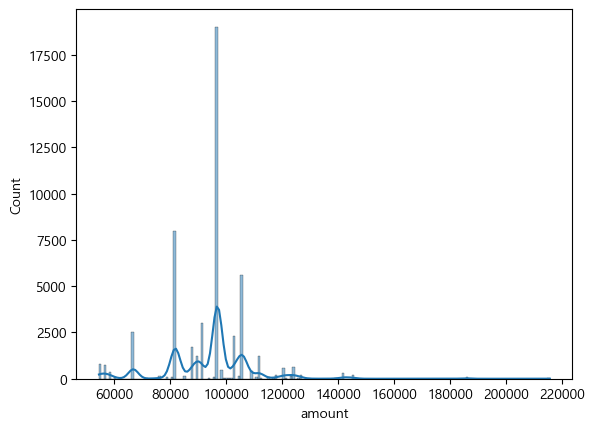

In [9]:
# 단일변수일때 연속형
sns.histplot(data=df_TOCC_choose, x='amount', kde=True)

In [10]:
# 연속형 / 연속형 : 상관계수
df_TOCC_choose.corr() # 관계성 있을 경우 pairplot()

C:\Users\01-02\AppData\Local\Temp\ipykernel_5924\2729372373.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_TOCC_choose.corr() # 관계성 있을 경우 pairplot()


,amount,age
amount,1.000000,-0.003537
age,-0.003537,1.000000


<Axes: xlabel='product', ylabel='amount'>

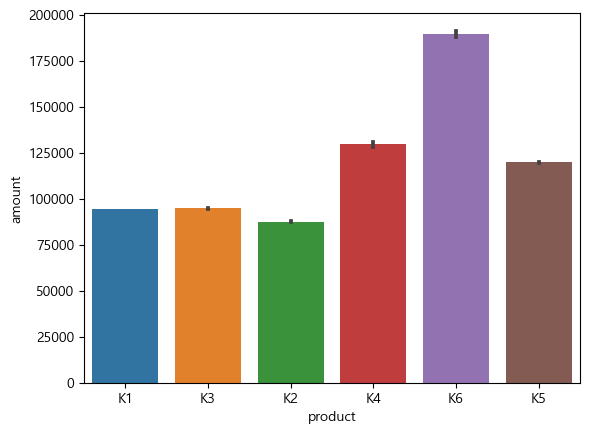

In [11]:
# 범주형 / 연속형 : 최상/최하 갯수 선택(항목 중에 영향을 주는 것을 선택)
# 항목 2개 이상 필요
sns.barplot(data=df_TOCC_choose, x='product' , y='amount')

In [12]:
## 변수 안에서 원하는 항목 필터링
conditions = (df_TOCC_choose['product'] == 'K4') | (df_TOCC_choose['product'] == 'K5') | (df_TOCC_choose['product'] == 'K6')
df_TOCC_choose_product = df_TOCC_choose.loc[conditions]
df_TOCC_choose_product

,type_of_contract,datetime,product,amount,age
58,렌탈,2019-10-21,K4,126900,28.0
110,렌탈,2019-10-21,K4,125700,23.0
156,렌탈,2019-10-21,K4,125700,41.0
230,렌탈,2019-10-21,K6,185700,45.0
325,렌탈,2019-10-21,K6,185700,NaN
...,...,...,...,...,...
51168,렌탈,2020-02-03,K5,120900,NaN
51173,렌탈,2020-02-03,K5,126900,NaN
51184,렌탈,2020-02-03,K6,185700,NaN
51295,렌탈,2020-02-03,K5,120900,48.0


<Axes: xlabel='product', ylabel='amount'>

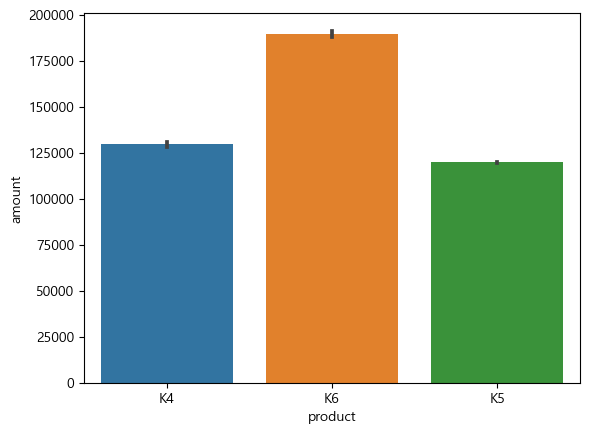

In [13]:
sns.barplot(data=df_TOCC_choose_product, x='product' , y='amount')

<Axes: xlabel='datetime', ylabel='amount'>

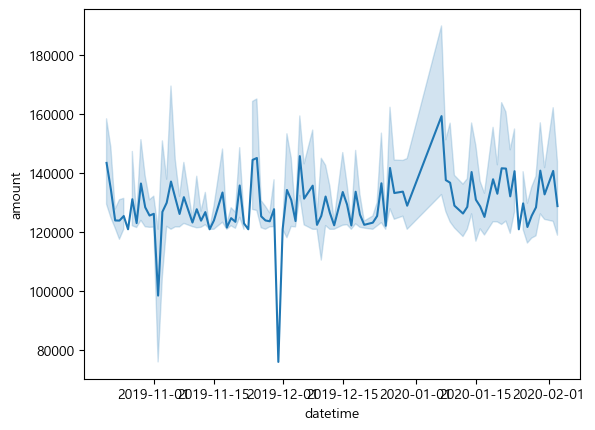

In [14]:
## 순서형 / 연속형
sns.lineplot(data=df_TOCC_choose_product, x='datetime' , y='amount')

In [16]:
# .loc[] 컬럼이 없는 경우, 있는 []
df_TOCC_choose_product['day_name'] = df_TOCC_choose_product['datetime'].dt.day_name()
df_TOCC_choose_product['day_name'].value_counts()

C:\Users\01-02\AppData\Local\Temp\ipykernel_5924\3740212672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TOCC_choose_product['day_name'] = df_TOCC_choose_product['datetime'].dt.day_name()


Thursday     205
Friday       188
Tuesday      184
Monday       173
Wednesday    173
Sunday       163
Saturday       6
Name: day_name, dtype: int64

<Axes: xlabel='day_name', ylabel='amount'>

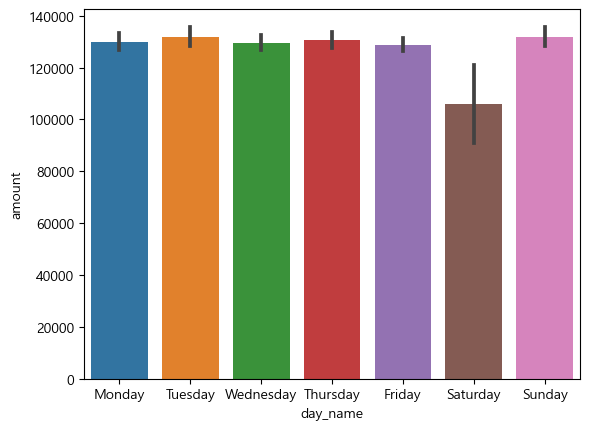

In [17]:
# 범주형 / 연속형
sns.barplot(data=df_TOCC_choose_product, x='day_name' , y= 'amount')

#### 보고서
- 변수간 상관성 확인용
    - 목표 변수 : 비정규 분포
    - 설명 변수 
        - type_of_contract(범주형) : 2개 항목
        - product(범주형) : 상위 3개 항목
        - age(연속형) : 상관 계수가 -0.003539 < 0.5 작아서 설명 변수로 채택 어려움.
        - datetime(순서형) : 분포 특성상 요일별 변환
        - day_name : 요일별 분석 위한 컬럼 추가